
# Generador de textos

## Definición

Para la realizacion de esta libreta fue elaborado a partir de esta otra [libreta](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb) la cual se encuentra en el idioma ingles, utilizaremos las bases para nuestro proyecto haciendo algunas modificaciónes con nuestro dataset de [municipios de México](datos/BIBLIA_COMPLETA.txt).
Nuestro proposito es generar parrafos los cuales se generan caracter por caracter a partir deldocumento de la biblia utilizando el framework de redes profundas **PyTorch**.




## Preparación de datos 

Si no tienes instalada la libreria unidecode ingresa el siguiente comando en Linux
```
conda install -c anaconda unidecode
```

In [1]:
import unidecode
import string
import random
import re

#para la clase RNN
import torch
import torch.nn as nn
from torch.autograd import Variable

#Para medir tiempos de ejecucion y calculos 
import time, math

todos_caracteres = string.printable
n_caracteres = len(todos_caracteres)

archivo = unidecode.unidecode(open('datos/DonQuijote.txt',encoding="UTF-8").read())
tam_archivo = len(archivo)
print('Tamaño del archivo en caracteres: ', tam_archivo)

FileNotFoundError: [Errno 2] No such file or directory: 'datos/DonQuijote.txt'

Ahora fragmentaremos el texto

In [2]:
longitud_fragmento = 1000

def fragmento_aleatorio():
    i_ini = random.randint(0, tam_archivo - longitud_fragmento)
    i_final = i_ini + longitud_fragmento + 1
    return archivo[i_ini:i_final]

print(fragmento_aleatorio())

e
que te vuelves al sicut erat; habla a lo llano, a lo liso, a lo no
intricado, como muchas veces te he dicho, y veras como te vale un pan por
ciento.

-No se que mala ventura es esta mia -respondio Sancho-, que no se decir
razon sin refran, ni refran que no me parezca razon; pero yo me enmendare,
si pudiere.

Y, con esto, ceso por entonces su platica.





Capitulo LXXII. De como don Quijote y Sancho llegaron a su aldea


Todo aquel dia, esperando la noche, estuvieron en aquel lugar y meson don
Quijote y Sancho: el uno, para acabar en la campana rasa la tanda de su
diciplina, y el otro, para ver el fin della, en el cual consistia el de su
deseo. Llego en esto al meson un caminante a caballo, con tres o cuatro
criados, uno de los cuales dijo al que el senor dellos parecia:

-Aqui puede vuestra merced, senor don Alvaro Tarfe, pasar hoy la siesta: la
posada parece limpia y fresca.

Oyendo esto don Quijote, le dijo a Sancho:

-Mira, Sancho: cuando yo hojee aquel libro de la segunda parte 

## Construyendo el modelo

In [3]:
class RNN(nn.Module):
    def __init__(self, tam_entrada, tam_oculto, tam_salida, num_capas=1):
        super(RNN, self).__init__()
        self.tam_entrada = tam_entrada
        self.tam_oculto = tam_oculto
        self.tam_salida = tam_salida
        self.num_capas = num_capas
        
        self.encoder = nn.Embedding(tam_entrada, tam_oculto)
        self.gru = nn.GRU(tam_oculto, tam_oculto, num_capas)
        self.decoder = nn.Linear(tam_oculto, tam_salida)
    
    def forward(self, entrada, oculta):
        entrada = self.encoder(entrada.view(1, -1))
        salida, oculta = self.gru(entrada.view(1, 1, -1), oculta)
        salida = self.decoder(salida.view(1, -1))
        return salida, oculta

    def init_hidden(self):
        return Variable(torch.zeros(self.num_capas, 1, self.tam_oculto))

## Entradas y objetivos

In [4]:
# Convierta la cadena en una lista larga
def caracter_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = todos_caracteres.index(string[c])
    return Variable(tensor)

print(caracter_tensor('abcDEF'))

Variable containing:
 10
 11
 12
 39
 40
 41
[torch.LongTensor of size 6]



In [5]:
def conjunto_entrenamiento_aleatorio():    
    pedazo = fragmento_aleatorio()
    entrada = caracter_tensor(pedazo[:-1])
    objetivo = caracter_tensor(pedazo[1:])
    return entrada, objetivo

## Evaluando

Para evaluar la red la alimentaremos con un carácter a la vez, usaremos los resultados de la red como una distribución de probabilidad para el siguiente carácter y repetiremos este proceso.

In [6]:
def evaluar(prime_str='A', predict_len=100, temperature=0.8):
    oculta = decoder.init_hidden()
    entrada_principal = caracter_tensor(prime_str)
    prediccion = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, oculta = decoder(entrada_principal[p], oculta)
    entrada = entrada_principal[-1]
    
    for p in range(predict_len):
        salida, oculta = decoder(entrada, oculta)
        
        # Muestra de la red como una distribución multinomial
        distribucion_salida = salida.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(distribucion_salida, 1)[0]
        
        # Add predicted character to string and use as next input
        caracter_predicho = todos_caracteres[top_i]
        prediccion += caracter_predicho
        entrada = caracter_tensor(caracter_predicho)

    return prediccion

## Entrenamiento

In [7]:
def tiempo(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [8]:
def entrenamiento(entrada, objetivo):
    oculta = decoder.init_hidden()
    decoder.zero_grad()
    perdida = 0

    for c in range(longitud_fragmento):
        salida, oculta = decoder(entrada[c], oculta)
        perdida += criterion(salida, objetivo[c])

    perdida.backward()
    decoder_optimizer.step()

    return perdida.data[0] / longitud_fragmento

Definimos los parámetros de entrenamiento, instanciamos el modelo y comenzamos a entrenar:

In [10]:
max_epoch = 4000 #numero de epoch para el entrenamiento
impresion = 100
graficar = 10
tam_oculto = 100
num_capas = 2
epsilon = 0.005

decoder = RNN(n_caracteres, tam_oculto, n_caracteres, num_capas)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=epsilon)
criterion = nn.CrossEntropyLoss()

comienzo = time.time()
historial_perdidas = []
prmedio_perdida = 0

for epoch in range(1, max_epoch + 1):
    perdida = entrenamiento(*conjunto_entrenamiento_aleatorio())       
    prmedio_perdida += perdida

    if epoch % impresion == 0:
        print('[%s (%d %d%%) %.4f]' % (tiempo(comienzo), epoch, epoch / max_epoch * 100, perdida))
        print(evaluar('J', 100), '\n')

    if epoch % graficar == 0:
        historial_perdidas.append(prmedio_perdida / graficar)
        prmedio_perdida = 0

 47s (100 2%) 2.1040]
J. a puon
seros cido, no, que de cen que ma hha endie, de que que no la, de que pasoo; tas acono abas 

 41s (200 5%) 1.9375]
Jecho el cabonbrando don Quijote de nanaciara senor que ala.
-ser llanda y de pidar desaque sotuenda  

 35s (300 7%) 1.8600]
Ja todo por en hiciando notre en en no que leciente el la me lacia los Quijote el tendien de los caba 

 29s (400 10%) 1.6649]
JKpora como puestara se lo pordes la mejoraron; y con tampare esterma, con receriese que esto la lleg 

 24s (500 12%) 1.7705]
J|$, y hablas que parte peredendo el sienta del que tubiendo ander le caste de cuasa de acazon el qui 

 18s (600 15%) 1.6333]
Jueno que lo se de
vero prando con tiene con pormino lugranda los con encamilon, y con fimos la ser q 

 10s (700 17%) 1.5713]
Jar a puntado.

-Agra male quecho de la abulesto seguian que nenorudora, y, y entre menor de han su n 

 2s (800 20%) 1.5649]
J, que hubos La verdad de quiere satra. En ala diente, mas dreseamado del arruego el ventito

## Graficación de los errores

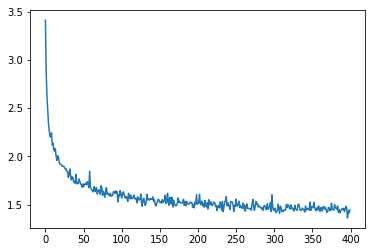

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(historial_perdidas)

## Resultados con diferentes temperaturas 

En la función de evaluación anterior, cada vez que se realiza una predicción, las salidas se dividen por el argumento "temperatura" pasado. Usar un número más alto hace que todas las acciones sean más equitativas y, por lo tanto, nos brinda salidas "más aleatorias".

Usar un valor más bajo (menos de 1) hace que las probabilidades altas contribuyan más. A medida que aumentamos la temperatura hacia cero, estamos eligiendo solo las salidas más probables.

In [17]:
print(evaluar('Caballero', 1000, temperature=0.8))

Caballero en los dos desperalosas y contras que cuester mostrar gustaron a quien a cosa esperanzado -respondio Sancho-, esta causara la muchas hermosas, o miraba les igual y desderecario su no agora junto en llevar generes demon no se demanes palabra mandandole, y le senor Lotara del respondida que se parecen la sanarse.

-Ni me suerte -respondio -respondio el -dijo don Quijote-. En tan donde por lascinerque, y encima pena en esto y llevado al comoda y del tiempo lo que de tenia aquellos con los ninguna has de terminar con mas haces estistan del loco, ve quiero ancho,
la de los que se ella, y no perder si podrido, la mas con su barca una manillon que los cosas del no las hermano, y las armas, estoco: que de su pace de mis hacellanos, casado y el cuales,
le me parece y a dormino, porque en las alaban el suelor por los senoras conde su negrativo sein yo hacian de tralicia y mas trabajos las lanzases de mi encimadole senorencias en mas cubra con todo barbero, y con tocado escudante su
raz

In [15]:
print(evaluar('Togoso', 1000, temperature=0.2))

Togoso de la manos de la caballero, y a lo que se la mano de la mano de la caballeros a los casa de su cola, y se deseo de la manos de la caballero de los casa de las maneras de la menos de las maneras de la mano de la caballero, senora con la cual tenia en la manos de las cuales de la casa de los casa de la manos de los casa, y desta manera la manos de la manos de los caballeros andantes y desta de las manos de las cosas de las cosas de la muchas cosas de su corazon de la menester de la caballero de la cierte de su amorado de la menos la casa de la menos de la caballero de la manos a los callesionas y desta de su casa de la menos de la manos, porque en el cielo a la mano de la casa de los casa de su calentes y desta desta desta manera de la manos, y desta persona de la casa de la cierta de la mano a la manos de la manos, y de la casa de la caballero de la caballero de la mano de la caballero de la manos de la mano de la mano de la manos de la manos de las ciertos no se de la caballeri

In [16]:
print(evaluar('Sancho', 1000, temperature=.5))

Sancho menos y en las fuertes, de que en ellos de los casa, con su manos, a lo que tiene de los casa, el caballero de las haber contentados de encantamentos le dejar las decir, senora caballero, y en mis poder que no hay el alido que los menos las locos dos deste contento de las popros en tus senoras los salir al colentes en el senor que en la
parte, a lo que sale a las partes por ellas que ser el calle de la cabeza, senor cuando la cosegustar los canas y deshonras de los colgar que se por la caminador de una de ser deste la menos a las intentas de mi comoridado de mucho que se se habia por su prestan las persona, porque dijo que me la cosa y despues de los maneras de ser con la caballero, y la mano a los por las postas, porque el cual la de penar sin presentados de su cual el encantando le senoranza y puesta a la perdurtencia mas ha de diliginar de las personas y cosas de ser el mal con las barbas y senoras tienes las lugar las pintadas de su menos en el camino que le ha de la median 